<h1> Building a Video Dataset </h1>

In this notebook, we build a generic `Video Dataset` that can be constructed from a basic directory layout. 

The code is heavily borrowed from [`torchvision`'s `Kinetics400`](https://github.com/pytorch/vision/blob/master/torchvision/datasets/kinetics.py), and is tweaked to accomodate more data augmentations and some utility functions to help us understand the dataset better.

<br>

---


### Things to consider when building a video dataset

* Pretrained models of video datasets require the input videos to be of a certain number of frames (8, 16, 32 are popular choices). 


* If our input videos exceed this size, we need to ensure that a sensible representation of them are inputted into the model in the required frame size. This is commonly done by making the dataset skip certain frames after every video i.e. if your video has 32 frames but you can only input 8 frames into your model, you could tell the dataset to take frames (1, 5, 9, 13, 17, 21, 25, 29) i.e. a `step_between_frames=3`. 


* Despite this, if your video is still too large, you could construct various different sequences of the video (this will be demonstrated later in the notebook). For each epoch, you would then send a different sequence to the model, picked at random (this NEXT/HERE?)

<br>

*All of the above will be demonstrated visually with special dummy videos to make things crystal clear later in this notebook*

<br>

In [2]:
from utils import *
from imports import *
from tfms_torch import *
from tfms_albumentations import *

Arguments such as `_video_width=0`, `_video_height=0` don't make much sense but are needed for speedy reading of videos. Behind the scenes, `torchvision` uses [`PyAV`](https://github.com/mikeboers/PyAV/), which in turn used `ffmpeg`, to read videos.

In [31]:
#export
from torchvision.datasets.utils import list_dir
from torchvision.datasets.folder import make_dataset
from torchvision.datasets.video_utils import VideoClips
from torchvision.datasets.vision import VisionDataset
import pandas as pd

class VideoDataset(VisionDataset):
    """
    Parameters
    ----------
        root : string
            Root directory of the dataset.
            
        frames_per_clip : int
            number of frames in a clip
            
        step_between_clips : int
            number of frames between each clip
            
        transform (callable, optional): A function/transform that  takes in a TxHxWxC video
            and returns a transformed version.

    Returns
    -------
        video : Tensor[T, H, W, C]
            Tensor of shape (T, H, W, C) where `T = num_frames`
            
        audio : Tensor[K, L]: 
            the audio frames, where `K` is the number of channels
            and `L` is the number of points
            
        label : int
            class of the video clip
    """

    def __init__(self, root, frames_per_clip, step_between_clips=1, frame_rate=None,
                 extensions=('mp4',), tfms_torch=None, tfms_albu=None, _precomputed_metadata=None,
                 num_workers=1, _video_width=0, _video_height=0,
                 _video_min_dimension=0, _audio_samples=0):
        super(VideoDataset, self).__init__(root)

        classes      = list(sorted(list_dir(root)))
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        self.samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file=None)
        self.classes = classes
        video_list   = [x[0] for x in self.samples]
        self.video_clips = VideoClips(
            video_list,
            frames_per_clip,
            step_between_clips,
            frame_rate,
            _precomputed_metadata,
            num_workers=num_workers,
            _video_width=_video_width,
            _video_height=_video_height,
            _video_min_dimension=_video_min_dimension,
            _audio_samples=_audio_samples,
        )
        self.tfms_torch = tfms_torch
        self.tfms_albu  = tfms_albu

    @property
    def metadata(self):
        return self.video_clips.metadata

    def get_info(self):
        fnames     = [f.rsplit('/')[-1] for f   in self.video_clips.metadata['video_paths']]
        classes    = [f.rsplit('/')[-2] for f   in data.video_clips.metadata['video_paths']]
        num_frames = [len(pts)          for pts in self.video_clips.metadata['video_pts']]
        fps        = [i                 for i   in self.video_clips.metadata['video_fps']]
        subclips   = [len(x)            for x   in self.video_clips.clips]
        

        info = pd.DataFrame(data    = list(zip(fnames, classes, num_frames, fps, subclips)),
                            columns = ['Filename', 'Class', '# Frames', 'FPS', '# Subclips'])
        return info
    
    def __len__(self):
        return self.video_clips.num_clips()

    def __getitem__(self, idx):
        video, audio, info, video_idx = self.video_clips.get_clip(idx)
        label = self.samples[video_idx][1]

        if self.tfms_albu is None: self.tfms = A.Compose([])
        if self.tfms_torch is not None:
            video = apply_tfms_albu(self.tfms_torch(video), self.tfms_albu)

        return video, audio, label

## Constructing a Minimal VideoDataset and Seeing What's Inside


### Constructed using dummy samples, and without transforms. The goal is to understand how videos are stored by the dataset, and what `step_between_clips` and `frames_per_clip` do.

<br>

In [32]:
!tree ../data/train

../data/train
├── class1
│   ├── c1-sample1.mp4
│   └── c1-sample2.mp4
└── class2
    ├── c2-sample1.mp4
    └── c2-sample2.mp4

2 directories, 4 files


In [33]:
Video('../data/train/class1/c1-sample1.mp4', width=400)
Video('../data/train/class1/c1-sample2.mp4', width=400)
Video('../data/train/class2/c2-sample1.mp4', width=400)
Video('../data/train/class2/c2-sample2.mp4', width=400)

In [34]:
def get_data(step=1, fpclip=32):
    return VideoDataset('../data/train/', step_between_clips=step, frames_per_clip=fpclip)

In [47]:
data = get_data()
data.get_info()
print(f'----------- The dataset has {len(data)} training samples -----------')

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


,Filename,Class,# Frames,FPS,# Subclips
0,c1-sample1.mp4,class1,32,25.0,1
1,c1-sample2.mp4,class1,47,25.0,16
2,c2-sample1.mp4,class2,17,25.0,0
3,c2-sample2.mp4,class2,13,25.0,0


----------- The dataset has 17 training samples -----------


In [48]:
print(f'Each sample returns {len(data[0])} items:')
print(f'-----------------------------------------')

print(f'#1 --> Video --> {data[0][0].shape}')
print(f'#2 --> Audio --> {data[0][1].shape}')
print(f'#2 --> Label --> {data[0][2]}')

Each sample returns 3 items:
-----------------------------------------
#1 --> Video --> torch.Size([32, 900, 1600, 3])
#2 --> Audio --> torch.Size([2, 31744])
#2 --> Label --> 0


### Step Between Clips = 1,
### Frames Per Clip = 32

<br>

As the data table above tells us, 1 subsample was created from the first sample, 16 from the second, and none from the others. <br>
These 16 samples are 16 consecutive series of 32 frames, from a total of 47 frames. 

<br>

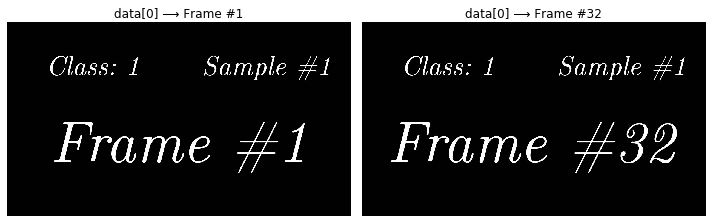

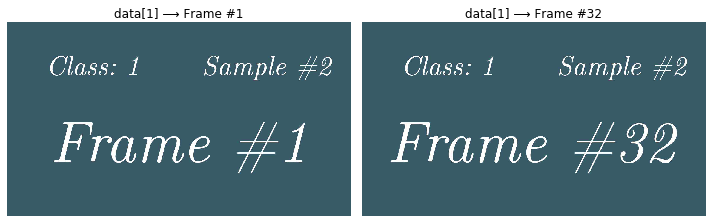

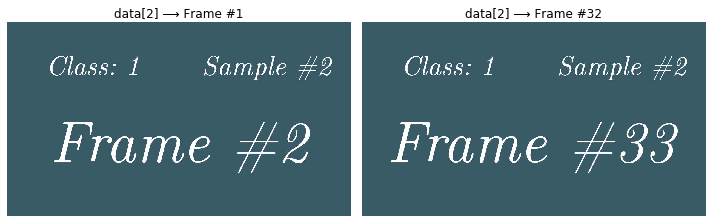

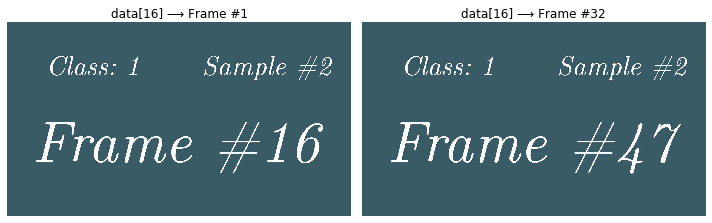

In [63]:
i = 0

plot = lambda i:plot_adjacent(data[i][0], figsize=(10, 6), prefix=f'data[{i}] ⟶ ')

plot(0)
plot(1)
plot(2)
plot(16)

### Step Between Clips = 8,
### Frames Per Clip = 32

In [66]:
data = get_data(step=8, fpclip=32)
data.get_info()

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


,Filename,Class,# Frames,FPS,# Subclips
0,c1-sample1.mp4,class1,32,25.0,1
1,c1-sample2.mp4,class1,47,25.0,2
2,c2-sample1.mp4,class2,17,25.0,0
3,c2-sample2.mp4,class2,13,25.0,0


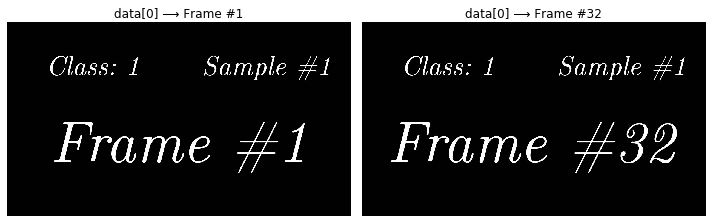

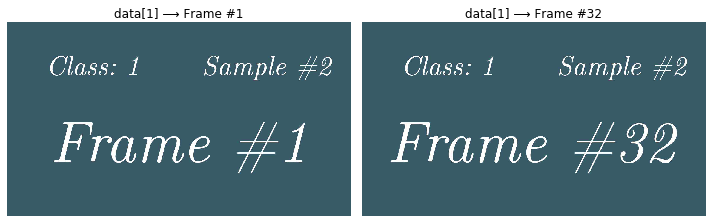

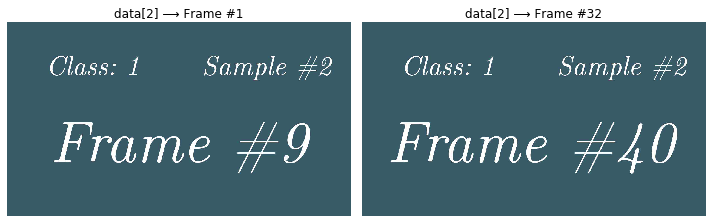

In [67]:
plot(0)
plot(1)
plot(2)

### Step Between Clips = 4,
### Frames Per Clip = 32

In [69]:
data = get_data(step=4, fpclip=32)
data.get_info()

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


,Filename,Class,# Frames,FPS,# Subclips
0,c1-sample1.mp4,class1,32,25.0,1
1,c1-sample2.mp4,class1,47,25.0,4
2,c2-sample1.mp4,class2,17,25.0,0
3,c2-sample2.mp4,class2,13,25.0,0


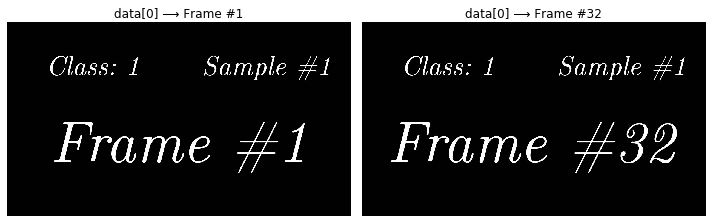

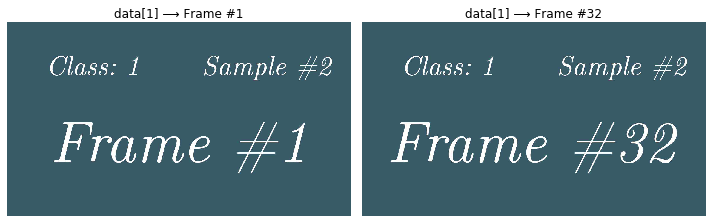

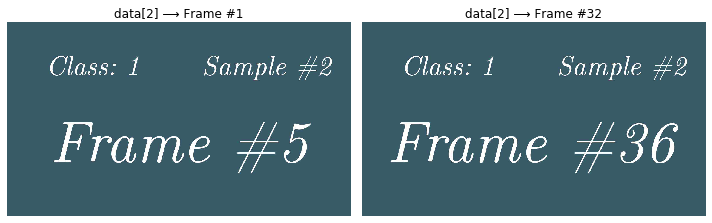

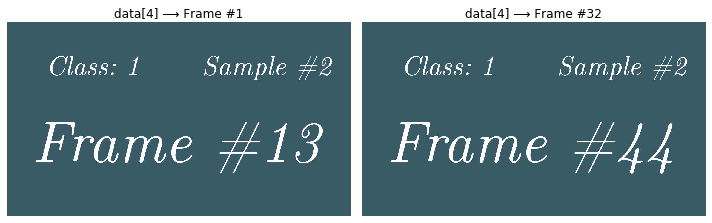

In [71]:
plot(0)
plot(1)
plot(2)
plot(4)

## .